* Python code replication of:
" https://www.kaggle.com/victorchernozhukov/r-notebook-experiment-on-orthogonal-learning "
* Created by: Alexander Quispe and Anzony Quispe 

# Simulation Design

In [1]:
import hdmpy
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

C:\Users\Roberto\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Roberto\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Simulation Design 1

In [18]:
# Set seed
np.random.seed(0)
B = 50
Naive = np.zeros( B )
Orthogonal = np.zeros( B )

In [19]:
    n = 100
    p = 100
    beta = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )
    gamma = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )

    mean = 0
    sd = 1
    X = np.random.normal( mean , sd, n * p ).reshape( n, p )

    D = ( X @ gamma ) + np.random.normal( mean , sd, n ).reshape( n, 1 )/4 # We reshape because in r when we sum a vecto with a matrix it sum by column
    
    # DGP 
    Y = D + ( X @ beta ) + np.random.normal( mean , sd, n ).reshape( n, 1 )

    # single selection method
    r_lasso_estimation = hdmpy.rlasso( np.concatenate( ( D , X ) , axis  =  1 ) , Y , post = True ) # Regress main equation by lasso

coef_array = r_lasso_estimation.est[ 'coefficients' ].iloc[ 2:, :].to_numpy()    # Get "X" coefficients 

In [20]:
r_lasso_estimation.est

{'coefficients':                     0
 (Intercept)  0.033276
 V1           2.031206
 V2           0.000000
 V3           0.000000
 V4           0.000000
 ...               ...
 V97          0.000000
 V98          0.000000
 V99          0.000000
 V100         0.000000
 V101         0.000000
 
 [102 rows x 1 columns],
 'beta':              0
 V1    2.031206
 V2    0.000000
 V3    0.000000
 V4    0.000000
 V5    0.000000
 ...        ...
 V97   0.000000
 V98   0.000000
 V99   0.000000
 V100  0.000000
 V101  0.000000
 
 [101 rows x 1 columns],
 'intercept': 0    0.033276
 dtype: float64,
 'index':           0
 V1     True
 V2    False
 V3    False
 V4    False
 V5    False
 ...     ...
 V97   False
 V98   False
 V99   False
 V100  False
 V101  False
 
 [101 rows x 1 columns],
 'lambda':                0
 V1    102.820598
 V2     94.775265
 V3     89.717230
 V4    104.692844
 V5     76.701778
 ...          ...
 V97    93.959217
 V98    86.241599
 V99    78.501905
 V100   83.899517
 V101  10

In [8]:
for i in range( 0, B ):
    n = 100
    p = 100
    beta = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )
    gamma = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )

    mean = 0
    sd = 1
    X = np.random.normal( mean , sd, n * p ).reshape( n, p )

    D = ( X @ gamma ) + np.random.normal( mean , sd, n ).reshape( n, 1 )/4 # We reshape because in r when we sum a vecto with a matrix it sum by column
    
    # DGP 
    Y = D + ( X @ beta ) + np.random.normal( mean , sd, n ).reshape( n, 1 )

    # single selection method
    r_lasso_estimation = hdmpy.rlasso( np.concatenate( ( D , X ) , axis  =  1 ) , Y , post = True ) # Regress main equation by lasso

    coef_array = r_lasso_estimation.est[ 'coefficients' ].iloc[ 2:, :].to_numpy()    # Get "X" coefficients 

    SX_IDs = np.where( coef_array != 0 )[0]

    # In case all X coefficients are zero, then regress Y on D
    if sum(SX_IDs) == 0 : 
        Naive[ i ] = sm.OLS( Y , sm.add_constant(D) ).fit().summary2().tables[1].round(3).iloc[ 1, 0 ] 

    # Otherwise, then regress Y on X and D (but only in the selected coefficients)
    elif sum( SX_IDs ) > 0 :
        X_D = np.concatenate( ( D, X[:, SX_IDs ] ) , axis = 1 )
        Naive[ i ] = sm.OLS( Y , sm.add_constant( X_D ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

    # In both cases we save D coefficient
        
    # Regress residuals. 
    resY = hdmpy.rlasso( X , Y , post = False ).est[ 'residuals' ]
    resD = hdmpy.rlasso( X , D , post = False ).est[ 'residuals' ]
    Orthogonal[ i ] = sm.OLS( resY , sm.add_constant( resD ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

In [9]:
Orto_breaks = [-1.2, -1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
Naive_breaks = [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2]

Text(0.5, 0, 'Naive - True')

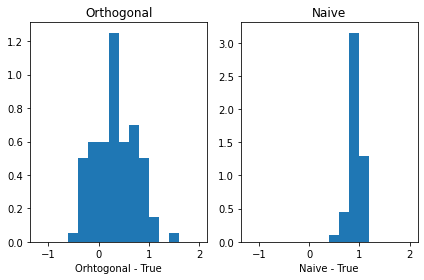

In [10]:
fig, axs = plt.subplots(1, 2, sharex= True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist( Orthogonal - 1 , range = (-2, 2), density = True , bins = Orto_breaks )
axs[1].hist( Naive - 1, range = (-2, 2), density = True , bins = Naive_breaks )

axs[0].title.set_text('Orthogonal')
axs[1].title.set_text('Naive')

axs[0].set_xlabel( 'Orhtogonal - True' )
axs[1].set_xlabel( 'Naive - True' )

# Simulation Design 2

In [11]:
# Set seed
np.random.seed(0)

for i in range( 0, B ):
    n = 100
    p = 100
    beta = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )
    gamma = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )

    mean = 0
    sd = 1
    X = np.random.normal( mean , sd, n * p ).reshape( n, p )

    D = ( X @ gamma ) + np.random.normal( mean , sd, n ).reshape( n, 1 )/4 # We reshape because in r when we sum a vecto with a matrix it sum by column
    Y = D + ( X @ beta ) + np.random.normal( mean , sd, n ).reshape( n, 1 )

    # single selectin method
    r_lasso_estimation = hdmpy.rlasso( np.concatenate( ( D , X ) , axis  =  1 ) , Y , post = True )

    coef_array = r_lasso_estimation.est[ 'coefficients' ].iloc[ 2:, :].to_numpy()

    SX_IDs = np.where( coef_array != 0 )[0]

    if sum(SX_IDs) == 0 : 
        Naive[ 0 ] = sm.OLS( Y , sm.add_constant(D) ).fit().summary2().tables[1].round(3).iloc[ 1, 0 ]

    elif sum( SX_IDs ) > 0 :
        X_D = np.concatenate( ( D, X[:, SX_IDs ] ) , axis = 1 )
        Naive[ i ] = sm.OLS( Y , sm.add_constant( X_D ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]


    resY = hdmpy.rlasso( X , Y , post = True ).est[ 'residuals' ]
    resD = hdmpy.rlasso( X , D , post = True ).est[ 'residuals' ]
    Orthogonal[ i ] = sm.OLS( resY , sm.add_constant( resD ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

Text(0.5, 0, 'Naive - True')

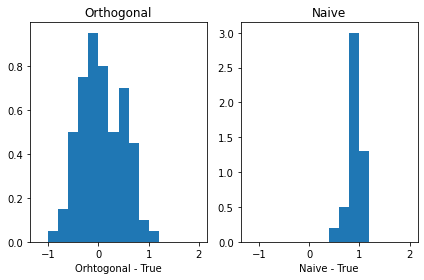

In [12]:
fig, axs = plt.subplots(1, 2, sharex= True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist( Orthogonal - 1 , range = (-2, 2), density = True , bins = Orto_breaks )
axs[1].hist( Naive - 1, range = (-2, 2), density = True , bins = Naive_breaks )

axs[0].title.set_text('Orthogonal')
axs[1].title.set_text('Naive')

axs[0].set_xlabel( 'Orhtogonal - True' )
axs[1].set_xlabel( 'Naive - True' )